



# Implied Volatility Modelling in Continuous time








In [ ]:
!pip install Quantlib

# Task 1 - Approach and Model Setup

To approach this project, I chose to use the QuantLib Python library. QuantLib offers a robust and extensible framework for financial modelling, particularly in the pricing and analysis of derivative instruments. It provides pre-implemented and validated models, such as the Heston model, which are both accurate and computationally efficient. This allows for a reliable setup compared to building a bespoke solution from scratch, which would require significantly more time, be more prone to implementation errors, and often lack the optimization that libraries like QuantLib offer.

---

## The Heston Stochastic Process

The Heston model is a widely used stochastic volatility model in finance. It assumes that the asset price follows a geometric Brownian motion, but with a variance that is itself stochastic. The model is described by the following system of SDEs:

### 1. Asset Price Dynamics
$$\
dS_t = \alpha S_t dt + \sqrt{\nu_t} S_t dW^t_S
$$

- $S_t$ Asset price at time *t*  
- $α$ Drift term (here equal to the risk-free rate *r*)  
- $νt$ Time-dependent variance  
- $dW_S^t$: Brownian motion for asset price  

This equation models the randomness in the asset price, modulated by a time-varying volatility.

---

### 2. Variance (Volatility Squared) Dynamics
$$\
d\nu_t = \kappa(\theta - \nu_t) dt + \xi \sqrt{\nu_t} dW^t_\nu
$$

- $ν_t$: Stochastic variance at time *t*  
- $κ$: Speed of mean reversion for variance  
- $θ$: Long-run average level of variance  
- $ξ$: Volatility of volatility ("vol of vol")  
- $dW_ν^t$: Brownian motion for volatility  

---

### Parameter Interpretations
- $νt$: The instantaneous variance, which evolves randomly over time and impacts how volatile the asset price is.  
- $κ$: The rate of mean reversion, determining how quickly νt is pulled back towards the average level θ.  
- $θ$: The long-term mean of variance. Over time, the variance tends to revert to this value.  
- $ξ$: Known as the volatility of volatility, this determines how erratic the variance itself is.  
- $ρ$: The correlation between the asset price and its volatility. Typically negative, as volatility tends to rise when prices fall (leverage effect).  
- $α$: Controls the expected return or drift of the asset price. In a risk-neutral setting, this is often set to the risk-free rate *r*.  

---

## QuantLib Implementation

QuantLib modularizes the Heston model setup as follows:

| Component              | Function                                                                 |
|------------------------|---------------------------------------------------------------------------|
| `HestonProcess`        | Models the joint dynamics of asset price and variance                     |
| `HestonModel`          | Wraps the process for pricing and calibration purposes                    |
| `AnalyticHestonEngine` | Computes option prices using a semi-analytical formula via characteristic functions |

By using these tools, I was able to efficiently simulate asset paths, construct the price surface, and later proceed with implied volatility extraction and Dupire model calibration as per the remaining tasks in the project.


In [ ]:
# Task 1 - Model Setup

import QuantLib as ql

calendar = ql.NullCalendar()  # define calendar with no holidays or weekends considered
day_count = ql.Actual365Fixed()    #allows time to be measured as actual number of days/365

S0 = ql.QuoteHandle(ql.SimpleQuote(200))

# Risk-free rate
r = 0.05
risk_free = ql.YieldTermStructureHandle(ql.FlatForward(0, calendar, r, day_count))   #creates a constant risk-free interest rate curve from time 0 at r

# Defining dividend for the purpose of using functions in the quantlib library
div_yield = 0.0
dividend = ql.YieldTermStructureHandle(ql.FlatForward(0, calendar, div_yield, day_count))


# Heston parameters
v0 = 0.04     # initial variance
kappa = 1.5   # mean reversion
theta = 0.04  # long-term variance
xi = 0.3   # vol of vol
rho = -0.7    # correlation

base_date = ql.Date(1, 1, 2023)
ql.Settings.instance().evaluationDate = base_date

#Define European Call option
def call_option(strike, maturity):

  ''' A function that defines a European Call option with Strike and Maturity as inputs'''

  maturity_days = int(maturity * 365)
  expiry_date = base_date + maturity_days

  payoff = ql.PlainVanillaPayoff(ql.Option.Call, strike)     #defines a vanilla call option
  exercise = ql.EuropeanExercise(expiry_date)  # converts time to dummy date which represents date of excercise/maturity , needed by engine
  option = ql.VanillaOption(payoff, exercise)    #options contract provided the payoff and excercise date defines previously

  return option

# Heston process and model
def heston_pricing(risk_free, dividend, S0, v0, kappa, theta, xi, rho, strike, maturity):

  ''' A function that prices a european call option using the Heston Model'''


  process = ql.HestonProcess(risk_free, dividend, S0, v0, kappa, theta, xi, rho)
  model = ql.HestonModel(process)

  engine_heston = ql.AnalyticHestonEngine(model)  #pricing engine - uses the model to price European options

  option = call_option(strike, maturity)
  option.setPricingEngine(engine_heston)    #we instruct on how to price this option i.e using the engine defined previously

  return option.NPV()


#TEST
maturity = 0.5
strike = 100

price = heston_pricing(risk_free, dividend, S0, v0, kappa, theta, xi, rho, strike, maturity)
print(price)

102.4662431979541


# Task 2 - Extracting and Interpreting the Option Price Surface

To construct the option price surface, I generated a grid of European call option prices across a range of strikes and maturities using the Heston model and the pricing engine defined in Task 1.

---

## Methodology

- **Strikes**: I chose 50 evenly spaced strike prices between **100** and **240**.  
  This range covers a wide spectrum of moneyness, with emphasis on **at-the-money (ATM)** and **in-the-money (ITM)** scenarios relative to the initial asset price \( $S_0 = 200$ \).  
  While a typical approach might involve strikes ranging from ±40% of \( $S_0$ \), I skewed the range toward lower strikes to better examine regions where options carry intrinsic value and meaningful time value.  

- **Maturities**: I selected 50 time points between **0 and 2 years**, which is a reasonable horizon for European-style options.  
  This allowed me to examine both **short-term** and **long-term** pricing behaviour.  

- **Pricing grid**: I initialized an empty \( $50 \times 50$ \) grid and populated it by applying the Heston pricing function from Question 1 across each combination of strike and maturity.  

This procedure produced a smooth and dense matrix of option prices, which I visualized as a 3D surface.  

---

## Observations

1. **Option prices increase with maturity**  
   Longer time to expiry provides more opportunity for the option to move in-the-money, thereby increasing expected payoff.  

2. **Option prices decrease with strike**  
   Higher strike prices reduce the likelihood of finishing in-the-money, so options with higher strikes are worth less.  

3. **Surface convexity**  
   The resulting option price surface is smooth and convex, particularly with respect to strike.  

4. **Steep slope around ATM ($ K \approx S_0 = 200 $)**  
   Options close to ATM are most sensitive to volatility changes and have the greatest exposure to uncertainty, leading to a steeper slope in this region.  

5. **Flattening in deep ITM and OTM regions**  
   - For **deep ITM options** (very low strikes), the price approaches the intrinsic value:  
     $
     C \approx S_0 - K
     $
   - For **deep OTM options** (very high strikes), the price approaches 0, as the probability of ending in-the-money becomes negligible.  

---

### Key Takeaway
The generated option price surface matches financial intuition:  
- **Higher maturity → higher price**  
- **Higher strike → lower price**  
- **Strong curvature near ATM**  

This validates that the Heston model implementation is working as expected, and provides a solid foundation for constructing the implied volatility surface in Task 3.


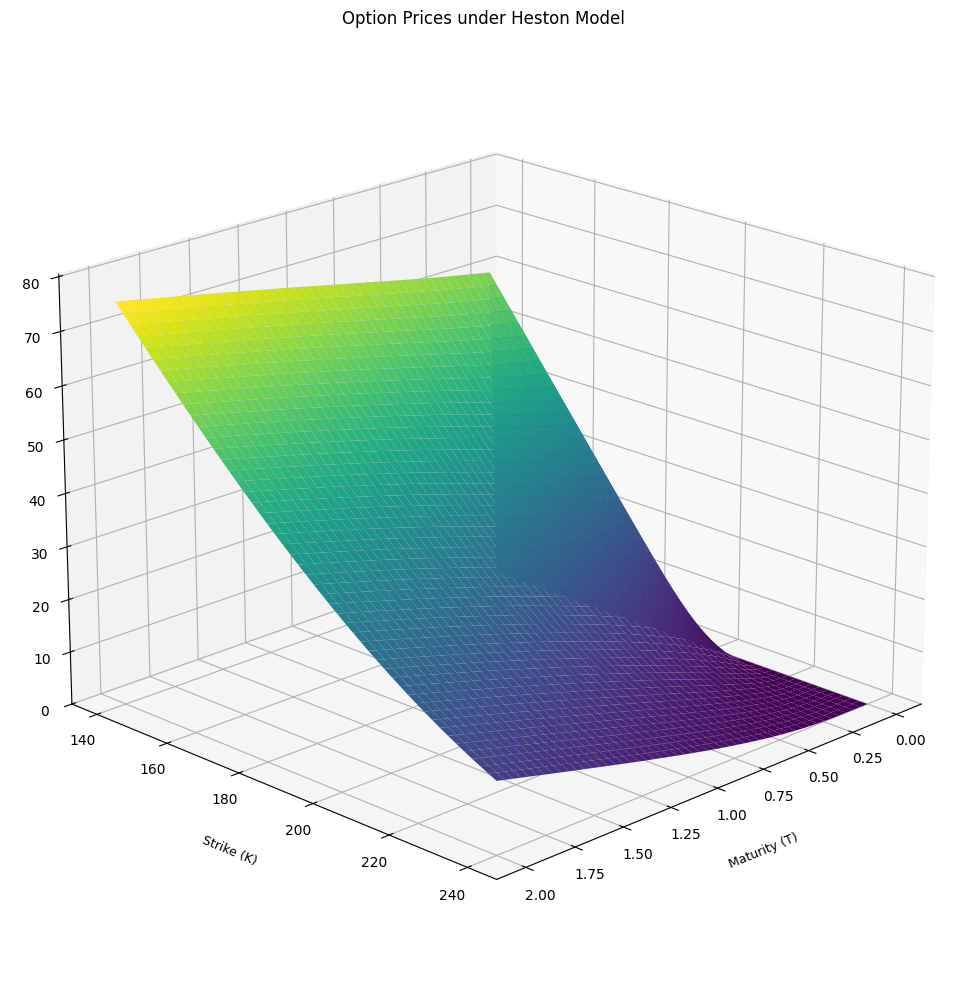

In [ ]:
#Task 2 - Extracting the Option Price Surface

import numpy as np

%matplotlib inline

# Creating 50x50 Grid of strikes and maturities
T = np.linspace(0,2,50)
K = np.linspace(140,240,50)


# Creating option prices grid
option_prices = np.zeros((len(T), len(K)))

for i, maturity in enumerate(T):
  for j, strike in enumerate(K):

    price = heston_pricing(risk_free, dividend, S0, v0, kappa, theta, xi, rho, strike, maturity)
    option_prices[i,j] = price

# Output result
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

T_grid, K_grid = np.meshgrid(K, T)
fig = plt.figure(figsize=(20, 10))
ax = fig.add_subplot(projection='3d')
ax.plot_surface(K_grid, T_grid, option_prices, cmap='viridis')
ax.set_xlabel("Maturity (T)", labelpad=15, fontsize=9)
ax.set_ylabel("Strike (K)", labelpad=15, fontsize=9)
ax.set_zlabel("Option Price", labelpad=20, fontsize=12)
ax.set_zlim(0, np.max(option_prices) + 5)


plt.title("Option Prices under Heston Model")
ax.view_init(elev=20, azim=45)
plt.tight_layout()

plt.show()

# Task 3 - Extracting and Interpreting the Implied Volatility Surface

Using the option price grid generated from the Heston model in Question 2, I computed the **implied volatility (IV) surface** by numerically inverting the Black–Scholes pricing formula.  

The goal is to find, for each option price, the volatility input in Black–Scholes that reproduces the same price. This produces a surface mapping volatility as a function of strike and maturity.

---

## Methodology

- **Input**: The \( $50 \times 50 $\) matrix of option prices from Question 2.  
- **Process**: For each combination of strike \(K\) and maturity \(T\), solve for the implied volatility \( $\sigma_{imp}(K,T)$ \) such that:

$$\
C^{BS}(S_0, K, T, r, \sigma_{imp}) = C^{Heston}(S_0, K, T, r)
$$

where:
- \( $C^{BS}$ \): Black–Scholes price of a European call option  
- \( $C^{Heston}$ \): Option price obtained from the Heston model  
- \( $\sigma_{imp}(K,T) $\): Implied volatility  

- **Output**: A smooth implied volatility surface defined across strikes and maturities.  

---

## Observations from the Implied Volatility Surface

1. **Volatility Skew**  
   - Implied volatility decreases with increasing strike:  
     $$\
     \frac{\partial \sigma_{imp}}{\partial K} < 0
     $$  
   - This forms a **downward-sloping skew**, consistent with market evidence that large downward moves in the underlying are more likely than large upward moves.  

2. **Term Structure**  
   - Implied volatility tends to decrease with increasing maturity, particularly at lower strikes.  
   - This reflects **short-term uncertainty** being higher due to news or shocks, while long-term volatility mean-reverts:  
     $$\
     \sigma_{imp}(T \to \infty) \to \sqrt{\theta}
     $$  
     where \( $\theta$ \) is the long-run variance in the Heston model.  

3. **Contrast with Black–Scholes**  
   - In Black–Scholes, volatility is assumed constant, so the IV surface would be flat.  
   - The **curved, asymmetric shape** produced by Heston illustrates how stochastic volatility better captures market realities.  

---

### Key Takeaway
The implied volatility surface shows the two central empirical features of option markets:
- **Volatility Skew/Smile**: OTM puts have higher IV than OTM calls.  
- **Term Structure**: Short-dated options have higher IV than long-dated ones.  

The Heston model successfully reproduces these features, validating its usefulness for realistic option pricing and risk management.


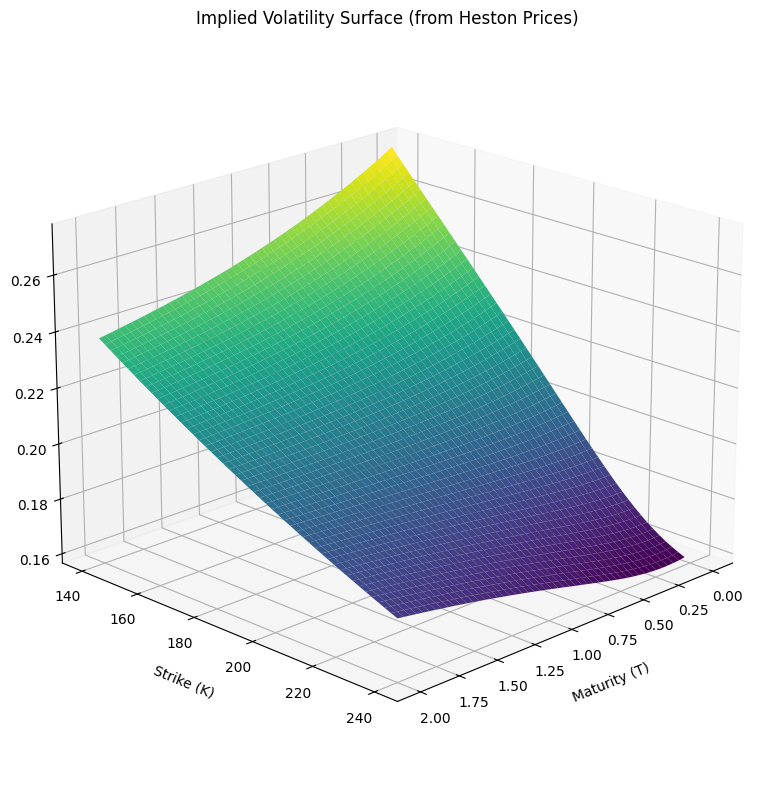

In [ ]:
# Task 3 - Extracting the Implied Volatility Surface

# Implied volatility grid
implied_vol = np.zeros((len(T), len(K)))

for i, maturity in enumerate(T):
    for j, strike in enumerate(K):
        # Define option
        option = call_option(strike,maturity)

        # Dummy vol structure
        vol_handle = ql.BlackVolTermStructureHandle(
            ql.BlackConstantVol(base_date, calendar, v0, day_count)
        )

        # Black-Scholes process
        bsm_process = ql.BlackScholesMertonProcess(S0, dividend, risk_free, vol_handle)
        engine = ql.AnalyticEuropeanEngine(bsm_process)
        option.setPricingEngine(engine)

        try:
            implied_vol[i, j] = option.impliedVolatility(option_prices[i, j],bsm_process)
        except RuntimeError:
            implied_vol[i, j] = np.nan
#Plotting Implied Volatility Surface

T_grid, K_grid = np.meshgrid(K, T)
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(projection='3d')
ax.plot_surface(K_grid, T_grid, implied_vol, cmap='viridis')
ax.set_xlabel("Maturity (T)", labelpad=10)
ax.set_ylabel("Strike (K)", labelpad=10)
ax.set_zlabel("Implied Volatility", labelpad=10)
ax.view_init(elev=30, azim=230)
plt.title("Implied Volatility Surface (from Heston Prices)")
plt.tight_layout()
ax.view_init(elev=20, azim=45)
plt.show()



# Task 4 - Dupire Local Volatility Model Pricing

The aim of this task is to use the **Dupire local volatility model**, calibrated to the implied volatility surface obtained in Task 3, to price a European call option with a **new strike and maturity** not included in the original grid.

---

## Methodology

### 1. Create Black Variance Surface
From the implied volatility grid \( $\sigma_{imp}(K,T)$ \) extracted in Task 3, construct a **Black Variance Surface** in QuantLib.  
This surface maps implied volatilities across strikes and maturities, enabling smooth interpolation.

### 2. Convert to Local Volatility Surface
Using Dupire’s formula, the local volatility function is obtained from the variance surface:

$$\
\sigma_{\text{loc}}^2(K,T) \;=\;
\frac{ \frac{\partial}{\partial T} \Big( T \sigma_{imp}^2(K,T) \Big) }
     { 1 - \frac{K}{C} \frac{\partial C}{\partial K} +
        \frac{1}{2} K^2 \frac{\partial^2 C}{\partial K^2} }
$$

This transformation captures how implied volatilities evolve into a deterministic local volatility function.  

### 3. Define Option to Price
A test option was selected with:  
- Strike: \($ K = 175 $\)  
- Maturity: \( $T = 1.5 \, \text{years} $\)  

These values lie **outside the original 50×50 grid**, ensuring interpolation from the Dupire surface is tested.

### 4. Price the Option
- Constructed a `BlackConstantVol` term structure from the local volatility value at \$(K=175, T=1.5)$\.  
- Passed into a `BlackScholesMertonProcess`.  
- Priced using QuantLib’s `AnalyticEuropeanEngine`.  

---

## Results

- **Dupire Model Price**: 44.8823  
- **Heston Model Price**: 43.4521  

---

## Observations

- The prices are similar but not identical.  
- The **Heston model** directly incorporates stochastic volatility and mean reversion.  
- The **Dupire model** instead derives a deterministic local volatility surface from the implied volatilities.  

### Key Insight
- Differences arise because the Dupire surface does not adapt to variance shocks—it encodes implied expectations only.  
- The Dupire model is **perfectly calibrated to the IV surface** but lacks stochastic dynamics.  
- Heston, while more complex, captures volatility clustering and randomness in a way Dupire cannot.  


In [ ]:
# Task 4 - Dupire Local Volatility Pricing

# Convert to days and clean
T_days = (T * 365).astype(int)
expiry_dates = [base_date + int(t) for t in T_days]

# Create the variance surface
expiry_dates = [d for d in expiry_dates if d > base_date]
implied_vol_clean = implied_vol[1:, :]  # remove first row if it matched base_date


# Interpolate Implied Vol surface
vol_surface = ql.BlackVarianceSurface(
    base_date,
    calendar,
    expiry_dates,
    list(K),
    implied_vol_clean.T.tolist(),
    day_count
)
vol_surface.setInterpolation()

# Build local vol surface from implied vol surface
local_vol_surface = ql.LocalVolSurface(
    ql.BlackVolTermStructureHandle(vol_surface),
    risk_free,
    dividend,
    S0
)


def dupire_pricing(strike, maturity, local_vol_surface, risk_free, dividend, S0, base_date):

    ''' Returns the price of a European Call option using the Dupire local volatility model. '''

    # Convert local volatility at given strike/maturity into a BlackConstantVol
    sigma_local = local_vol_surface.localVol(maturity, strike)
    sigma_lv = ql.BlackVolTermStructureHandle(
        ql.BlackConstantVol(base_date, ql.NullCalendar(), sigma_local, ql.Actual365Fixed())
    )

    # Build process and engine
    process_lv = ql.BlackScholesMertonProcess(S0, dividend, risk_free, sigma_lv)
    engine_lv = ql.AnalyticEuropeanEngine(process_lv)

    # Define option
    option = call_option(strike,maturity)
    option.setPricingEngine(engine_lv)

    return option.NPV()


T_new = 1.5   # time to maturity (in years)
K_new = 175   # strike price

# New option definition
dupire_price = dupire_pricing(K_new, T_new, local_vol_surface, risk_free, dividend, S0, base_date)
print(f"Dupire model price (strike= {K_new}, maturity={T_new}: {dupire_price}")

# Price with Heston model for reference
heston_price = heston_pricing(risk_free, dividend, S0, v0, kappa, theta, xi, rho, K_new, T_new)
print(f"Heston model price (strike={K_new}, maturity={T_new}: {heston_price}")



Dupire model price (strike= 175, maturity=1.5: 44.88231141413731
Heston model price (strike=175, maturity=1.5: 43.45211985095153


# Task 5 - Dynamic Pricing with Evolving Spot Prices

The goal of this task is to examine how the **Dupire model**, calibrated at \($ t = 0 $\), performs when used to price an option repeatedly as the **underlying asset evolves** under the Heston process.  
This mimics how a trader or risk manager would re-evaluate an option’s value over time without recalibrating the volatility surface.

---

## Methodology

### 1. Simulate Heston Paths
I simulated a single path of the Heston stochastic volatility process using QuantLib’s  
`GaussianMultiPathGenerator`, which generated time series of:

- Spot prices \( $S_t$ \)  
- Instantaneous variances \( $\nu_t$ \)  

for discrete time points from \( $t = 0$ \) to \( $t = 1.5 $\) years.  

The Heston SDE system used is:  

$$\
dS_t = \alpha S_t dt + \sqrt{\nu_t} S_t dW^t_S
$$
$$\
d\nu_t = \kappa (\theta - \nu_t) dt + \xi \sqrt{\nu_t} dW^t_\nu
$$

---

### 2. Rolling Pricing
At each time step \( $t_i$ \):  
1. Compute the remaining time to maturity:  
   $$\
   \tau = T - t_i
   $$  
2. Use the simulated spot \( $S_{t_i}$ \).  
3. Price the option using:
   - **Heston model**: update spot and variance dynamically.  
   - **Dupire model**: same spot but rely on the **static IV-calibrated local vol surface** from \( $t=0$ \).  

---

### 3. Plotting and Comparison
- Both price paths were plotted as a function of remaining time to maturity.  
- Comparison reveals how closely the Dupire-calibrated surface can track Heston dynamics.

---

## Observations

- At maturity (\( $T = 1.5$ \)), prices align with those from Question 4.  
- The Dupire model tracks Heston **reasonably well** for mid- and long-dated maturities.  
- However, Dupire prices generally lie **above Heston prices** throughout the time horizon.  

---

## Interpretation

- The **overpricing** arises because Dupire embeds higher implied volatilities in certain regions of the surface.  
- Since Dupire does not update with realized shocks to variance, it **overestimates option value** when actual volatility is trending downward (due to mean reversion).  
- Heston, by contrast, dynamically captures stochastic variance shocks.  

---

### Key Takeaway
- The Dupire model provides a good first-order static approximation calibrated to market IVs.  
- The Heston model, however, is better suited for **dynamic re-pricing**, as it evolves variance stochastically over time.  
- In practice, traders may use Dupire for **calibration and interpolation**, and Heston (or similar stochastic vol models) for **forward-looking scenario analysis**.  


In [ ]:
# Task 5: Dynamic Pricing of an Option with Evolving Heston Paths

# Simulate Heston paths
def simulate_heston_spot(
    time_points,
    risk_free,
    dividend,
    S0,
    v0,
    kappa,
    theta,
    xi,
    rho,
    n_steps=500,
    seed=45
):

    ''' Simulate a Heston process and return the spot price at a given time. '''
    # Create Heston process
    heston_process = ql.HestonProcess(risk_free, dividend, S0, v0, kappa, theta, xi, rho)

    # Filter time points to those before or at maturity (0.65 years)
    times = time_points  # Already in years


    # Create a TimeGrid with the exact times
    time_grid = ql.TimeGrid(times, len(times))
    random_generator = ql.UniformRandomGenerator(seed)
    random_sequence = ql.UniformRandomSequenceGenerator(2*(len(time_grid) - 1), random_generator)
    gaussian_sequence = ql.GaussianRandomSequenceGenerator(random_sequence)
    # Use the TimeGrid in GaussianMultiPathGenerator to store 2-dim Gaussian
    path_generator = ql.GaussianMultiPathGenerator(heston_process, time_grid, gaussian_sequence, False)



    # Generate one path
    path = path_generator.next().value()[0]
    spot_prices = [path[i] for i in range(len(times))]

    vol_path = path_generator.next().value()[1]
    volatility = [vol_path[i] for i in range(len(times))]

    # Print the simulated spot prices
    print("Times (Years):", times)
    print("Spot Prices:", spot_prices)
    print("Volatility:", volatility)
    return times, spot_prices, volatility

time_points = np.arange(0, 1.6, 0.1).round(2).tolist()
times, spot_prices, volatility = simulate_heston_spot(
    time_points,
    risk_free=risk_free,
    dividend=dividend,
    S0=S0,
    v0=v0,
    kappa=kappa,
    theta=theta,
    xi=xi,
    rho=rho
)




Times (Years): [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 1.1, 1.2, 1.3, 1.4, 1.5]
Spot Prices: [200.0, 226.8130437045366, 225.8104115623361, 224.11061021347356, 194.0308955233779, 177.93331961274475, 178.71992926222933, 155.2856912283463, 149.95421825110574, 153.57256597291746, 161.27221735857773, 170.57542616835846, 165.73280307884528, 183.48523989264044, 176.35319928021357, 171.64036269933254]
Volatility: [0.04, 0.026738797999592213, 0.029218639678084305, 0.03408840262265486, 0.004531987604859295, 0.010597357608070693, 0.014260455185449545, 0.03526624942018769, 0.02079362125852861, 0.006238516278403003, 0.004805588971486191, 1.9073295563963642e-05, 0.016781667158655464, 0.030872609983166138, 0.04049841581518427, 0.023181632840548225]


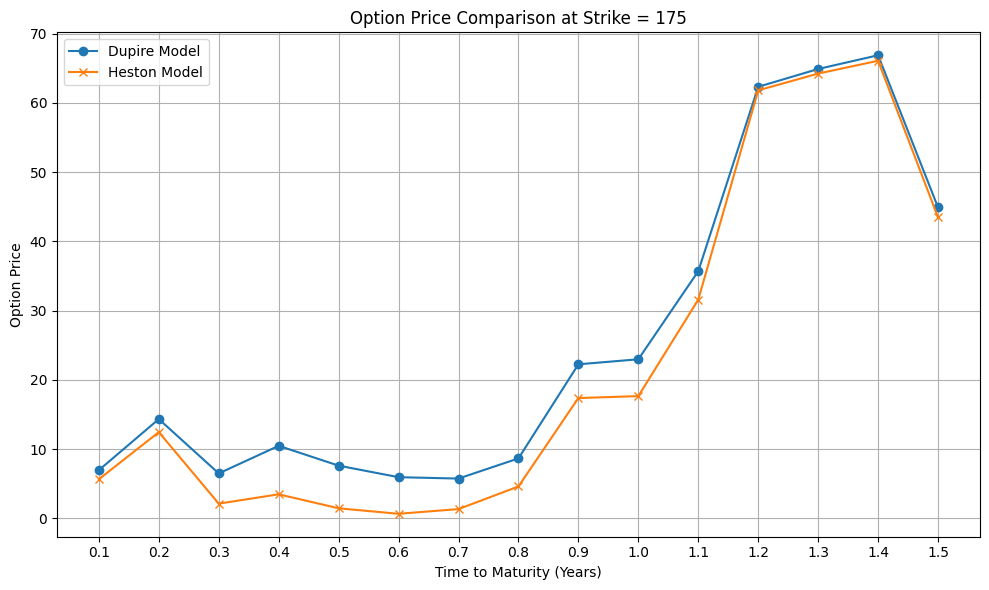

In [ ]:
# Use Spot Prices above to generate Heston and Dupire prices

strike = K_new

dupire_prices = []
true_prices = []
time_to_maturitylist =[]

for index, t in enumerate(time_points):
  time_to_maturity = T_new - t
  if time_to_maturity <= 0:
      continue  # option has expired
  time_to_maturitylist.append(time_to_maturity)
  option = call_option(strike, time_to_maturity)

  #Heston spot prices for each time t
  St = spot_prices[index]
  vol_t = volatility[index]

  #Heston price for maturity = remaining time, and current spot price = St
  spot_handle = ql.QuoteHandle(ql.SimpleQuote(St))
  heston_price = heston_pricing(risk_free, dividend, spot_handle, vol_t, kappa, theta, xi, rho, strike, time_to_maturity)
  true_prices.append(heston_price)


  # Dupire price using previous local vol surface
  dupire_price = dupire_pricing(strike, time_to_maturity, local_vol_surface, risk_free, dividend, spot_handle, base_date)
  dupire_prices.append(dupire_price)


plt.figure(figsize=(10, 6))

# Plot Dupire prices
plt.plot(time_to_maturitylist, dupire_prices, label="Dupire Model", marker='o')

# Plot Heston prices
plt.plot(time_to_maturitylist, true_prices, label="Heston Model", marker='x')

# Labels and title
plt.xlabel("Time to Maturity (Years)")
plt.ylabel("Option Price")
plt.title(f"Option Price Comparison at Strike = {strike}")
plt.legend()
plt.grid(True)
plt.xticks(time_to_maturitylist)  # Ensures the x-axis shows your exact times

# Show the plot
plt.tight_layout()
plt.show()

